# Import libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# MNIST preprocessing

In [3]:
# packing and unpacking images
def packcw(A,nr,nc):
    x = (A.T).reshape(nr*nc,1)
    return x

def unpackcw(x,nr,nc):
    A = x.reshape(nc,nr)
    return A.T

def packrw(A,nr,nc):
    x = A.reshape(nr*nc,1)
    return x

def unpackrw(x,nr,nc):
    A = x.reshape(nr,nc)
    return A

# generates a 784 element mask with columns deleted
# from the right side of the image towards the left
def generateColumnMask(delColumns):
    mask = np.ones((28, 28))
    mask[:, (28 - delColumns):] = 0
    maskVec = packcw(mask, 28, 28)
    return maskVec

# generate a 784 element mask with a square, with side
# length (sideLength), zero'd out of the middle
def generateCenterSquareMask(sideLength):
    mask = np.ones((28, 28))
    leftIdx = (28 - sideLength)/2
    rightIdx = (28 + sideLength)/2
    mask[leftIdx:rightIdx, leftIdx:rightIdx] = 0
    maskVec = packcw(mask, 28, 28)
    return maskVec

# zero out indices of a vector for a data matrix
# for a given mask
def hideData(data, mask):
    # copy the data
    newData = data.copy()
    
    # get indices from the mask
    x_idx = np.where([mask==1])[1]
    y_idx = np.where([mask==0])[1]
    
    # apply the mask
    newData[y_idx, :] = 0
    
    return newData, data[x_idx, :], data[y_idx, :]

In [4]:
# let's get our data
train = np.load('MNISTcwtrain1000.npy')
train = train.astype(float)/255
test = np.load('MNISTcwtest100.npy')
test = test.astype(float)/255

size = train.shape[0]
n_train = train.shape[1]
n_test = test.shape[1]

print '----MNIST dataset loaded----'
print 'Train data: %d x %d' %(size, n_train)
print 'Test data: %d x %d' %(size, n_test)

----MNIST dataset loaded----
Train data: 784 x 10000
Test data: 784 x 1000


(784, 10000)
(392, 10000)
(392, 10000)
(784, 1000)
(392, 1000)
(392, 1000)


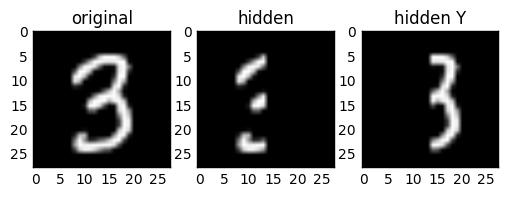

In [6]:
train_hideRight, Xtrain_hideRight, Ytrain_hideRight = hideData(train, generateColumnMask(14))
test_hideRight, Xtest_hideRight, Ytest_hideRight = hideData(test, generateColumnMask(14))

random = np.random.randint(0, 10000)
originalImg = unpackcw(train[:, random], 28, 28)
hiddenImg = unpackcw(train_hideRight[:, random], 28, 28)
hiddenVec = np.concatenate((np.zeros(28*14), Ytrain_hideRight[:, random]), axis = 0)
hiddenPart = unpackcw(hiddenVec, 28, 28)

print train_hideRight.shape
print Xtrain_hideRight.shape
print Ytrain_hideRight.shape
print test_hideRight.shape
print Xtest_hideRight.shape
print Ytest_hideRight.shape

plt.figure(1)
plt.subplot(1, 3, 1); plt.imshow(originalImg, cmap='gray'); plt.title('original')
plt.subplot(1, 3, 2);  plt.imshow(hiddenImg, cmap='gray'); plt.title('hidden')
plt.subplot(1, 3, 3);  plt.imshow(hiddenPart, cmap='gray'); plt.title('hidden Y')

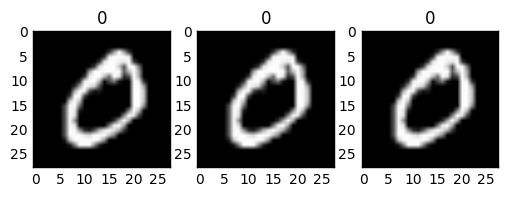

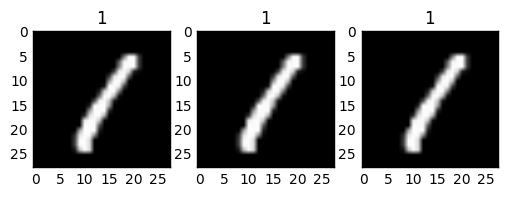

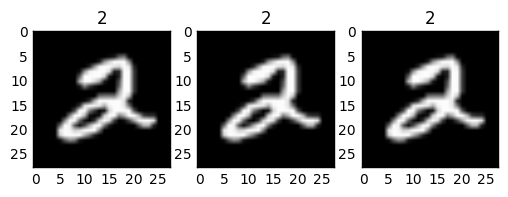

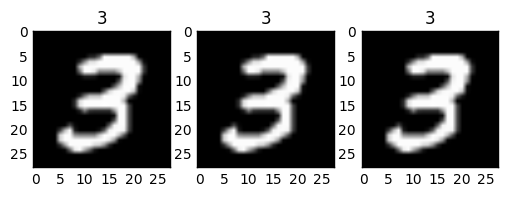

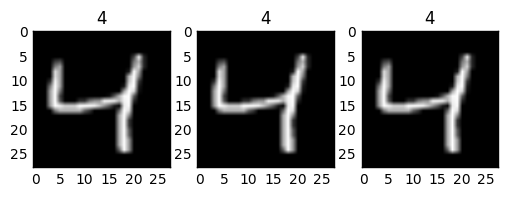

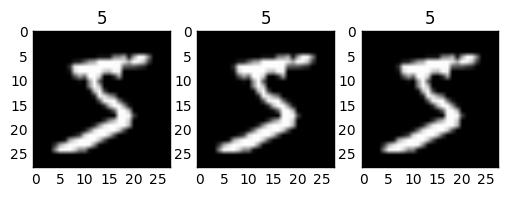

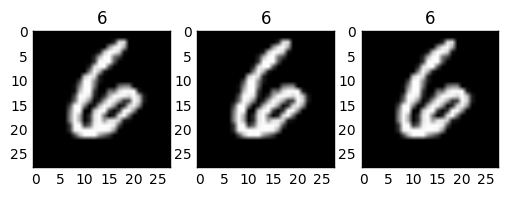

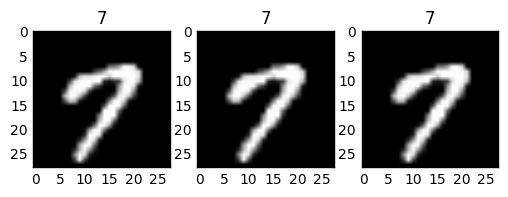

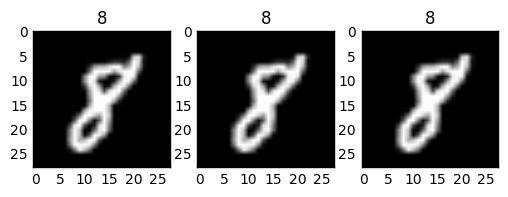

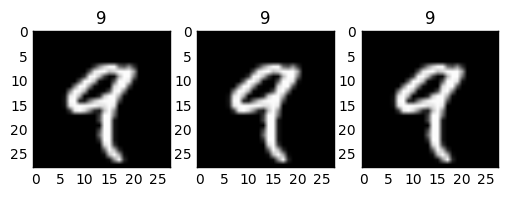

In [6]:
X_reduced = np.zeros((784, 10))

for i in range(10):
    X_reduced[:, i*1:(i+1)*1] = train[:, i*1000:i*1000 + 1]
    
    random1 = i#*10 + np.random.randint(0, 10)
    random2 = i#*10 + np.random.randint(0, 10)
    random3 = i#*10 + np.random.randint(0, 10)
    originalImg = unpackcw(X_reduced[:, random1], 28, 28)
    hiddenImg = unpackcw(X_reduced[:, random2], 28, 28)
    hiddenPart = unpackcw(X_reduced[:, random3], 28, 28)

    plt.figure(i)
    plt.subplot(1, 3, 1); plt.imshow(originalImg, cmap='gray'); plt.title('%d' %random1)
    plt.subplot(1, 3, 2);  plt.imshow(hiddenImg, cmap='gray'); plt.title('%d' %random2)
    plt.subplot(1, 3, 3);  plt.imshow(hiddenPart, cmap='gray'); plt.title('%d' %random3)

np.save('ReducedMNIST_1.npy', X_reduced)

In [15]:
check = np.concatenate((X_reduced, X_reduced[:, 0:50]), axis = 1)


(784, 1050)


In [16]:
train_hideRight, Xtrain_hideRight, Ytrain_hideRight = hideData(train, generateColumnMask(14))
test_hideRight, Xtest_hideRight, Ytest_hideRight = hideData(test, generateColumnMask(14))


In [17]:
print sum(sum(Xtrain_hideRight))

464630.486275
